In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pylab import Rectangle
import matplotlib.gridspec as gridspec
from collections import Counter
import numpy as np
import pandas as pd
import cnn 
import importlib 
import cv2
import scipy.signal
import scipy.stats
from tools.load_nc import load_nc_sat, load_nc_sinmod, load_nc_insitu
from tools import grid_conversion
from scipy.ndimage.filters import gaussian_filter
import datetime as dt
import tools.compare_tools
from tools.compare_tools import rotate_vector

C:\Users\47415\anaconda3\envs\cnn\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


In [ ]:
%%capture 
importlib.reload(cnn)
sizes2 = np.arange(60, 81, 5)
sizes2 = [60]
accuracies2, sigma2, time2 = cnn.find_best_input_size(sizes2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

#sizes = np.arange(5, 101, 5)
ax.errorbar(sizes, accuracies, sigma, linestyle='None', marker='^')
for i, v in enumerate(accuracies):
    ax.text(sizes[i]+1, v+0.001, "%0.2f" %time[i])#, ha="center")

In [ ]:
importlib.reload(cnn)
cnn.train_model()

## Distribution of features, show that it is Gaussian for standardization

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#fig, ax = plt.subplots(1,1)#,figsize=(10,12))
fig = plt.figure(figsize=(10,6))
#ax = fig.add_subplot(111)

# use a gray background
ax = plt.axes(facecolor='#E6E6E6')
ax.set_axisbelow(True)
# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)


uvel_path = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/uvel_train.npz'
vvel_path = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/vvel_train.npz'

with np.load(uvel_path, allow_pickle=True) as data:
    x = data['arr_0'][:,0]
N = len(x)
y = np.zeros((N, 20, 20))
for i in range(N):
    y[i] = cv2.resize(x[i], dsize=(20, 20), interpolation=cv2.INTER_CUBIC) 
y = y.flatten()
hist, bins = np.histogram(y[np.isfinite(y)], 200)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax.bar(center, hist, align='center', width=width)

with np.load(vvel_path, allow_pickle=True) as data:
    x = data['arr_0'][:,0]
N = len(x)
y = np.zeros((N, 20, 20))
for i in range(N):
    y[i] = cv2.resize(x[i], dsize=(20, 20), interpolation=cv2.INTER_CUBIC) 
y = y.flatten()
hist, bins = np.histogram(y[np.isfinite(y)], 200)

width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax.bar(center, hist, align='center', width=width, alpha=0.5)

ax.set_xlim([-0.5,0.5])
#ax[1].set_xlim([-0.5,0.5])
plt.legend(['uvel features', 'vvel features'])
plt.xlabel('ms$^{-1}$', size=12)

plt.show()


## Full grid

In [4]:
cmems_path = 'D:/master/data/compare/satellite/phys_469.nc'
sinmod_path = 'D:/master/data/compare/sinmod/samples_2017.06.05_nonoverlap.nc'
lon,lat,sst,ssl_sat,sal,uvel,vvel = load_nc_sat(cmems_path)
xc,yc,depth,_,_,sst,ssl_sinmod,sal,uvel,vvel = load_nc_sinmod(sinmod_path)

In [10]:
insitu_path = 'D:/master/data/compare/satellite2/phys_173.nc'
lon2,lat2,_,ssl2,_,_,_,_ = load_nc_insitu(insitu_path) 

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(16,8), dpi=150)

ax[0].pcolormesh(lon, lat, ssl_sat.T)
ax[0].set_title('CMEMS-phys', fontsize=14)
ax[0].set_xlabel('Longitude [$^\circ$]', fontsize=12)
ax[0].set_ylabel('Latitude [$^\circ$]', fontsize=12)
ax[1].pcolormesh(xc, yc, ssl_sinmod.T)
ax[1].set_title('SINMOD', fontsize=14)
ax[1].set_xlabel('X [km]', fontsize=12)
ax[1].set_ylabel('Y [km]', fontsize=12)

In [11]:
import tools.grid_conversion
x, y = grid_conversion.bl2xy(*np.meshgrid(lon, lat), FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)
x2, y2 = grid_conversion.bl2xy(*np.meshgrid(lon2, lat2), FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)

Text(0, 0.5, 'Y [km]')

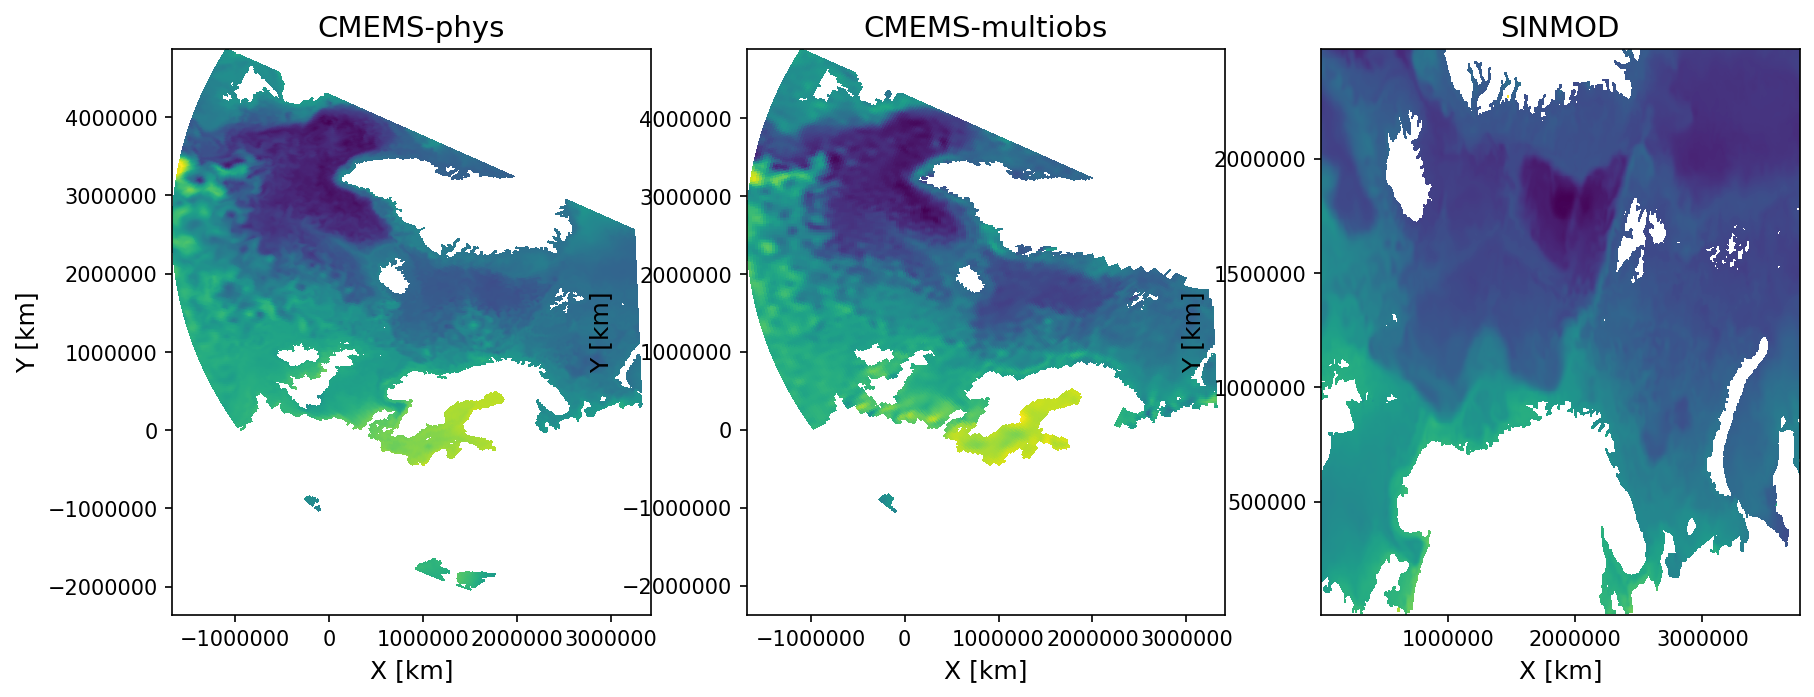

In [16]:
fig, ax = plt.subplots(1,3,figsize=(14,5), dpi=150)

ax[0].pcolormesh(x, y, ssl_sat.T)
ax[0].set_title('CMEMS-phys', fontsize=14)
ax[0].set_xlabel('X [km]', fontsize=12)
ax[0].set_ylabel('Y [km]', fontsize=12)
ax[1].pcolormesh(x2, y2, ssl2.T)
ax[1].set_title('CMEMS-multiobs', fontsize=14)
ax[1].set_xlabel('X [km]', fontsize=12)
ax[1].set_ylabel('Y [km]', fontsize=12)
ax[2].pcolormesh(xc, yc, ssl_sinmod.T)
ax[2].set_title('SINMOD', fontsize=14)
ax[2].set_xlabel('X [km]', fontsize=12)
ax[2].set_ylabel('Y [km]', fontsize=12)

## Create sequence of predictions 

In [ ]:
img1 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_183.png')
img2 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_184.png')
img3 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_185.png')
img4 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_186.png')
img5 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_187.png')
img6 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_188.png')
img7 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_189.png')
img8 = mpimg.imread('C:/Users/47415/Master/images/compare/multi/svalGronNor/compare_image_190.png')

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(10,12), dpi=250)
fig.subplots_adjust(wspace=0.01, hspace=0)

def add_frame(axis):
    autoAxis = axis.axis()
    rec = Rectangle((autoAxis[0]-0.7,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+1,(autoAxis[3]-autoAxis[2])+0.4,fill=False,lw=1)
    rec = axis.add_patch(rec)
    rec.set_clip_on(False)
    
    
ax[0,0].imshow(img1)
ax[0,0].set_title("2016-11-30")
ax[0,0].axis('off')
add_frame(ax[0,0])

ax[0,1].imshow(img2)
ax[0,1].set_title("2016-12-01")
ax[0,1].axis('off')
add_frame(ax[0,1])

ax[1,0].imshow(img3)
ax[1,0].set_title("2016-12-02")
ax[1,0].axis('off')
add_frame(ax[1,0])

ax[1,1].imshow(img4)
ax[1,1].set_title("2016-12-03")
ax[1,1].axis('off')
add_frame(ax[1,1])

ax[2,0].imshow(img5)
ax[2,0].set_title("2016-12-04")
ax[2,0].axis('off')
add_frame(ax[2,0])

ax[2,1].imshow(img6)
ax[2,1].set_title("2016-12-05")
ax[2,1].axis('off')
add_frame(ax[2,1])

ax[3,0].imshow(img7)
ax[3,0].set_title("2016-12-06")
ax[3,0].axis('off')
add_frame(ax[3,0])

ax[3,1].imshow(img8)
ax[3,1].set_title("2016-12-07")
ax[3,1].axis('off')
plt.tight_layout()
add_frame(ax[3,1])



plt.savefig('C:/Users/47415/Master/images/report/svalGronNor.png', bbox_inches='tight')

## Count labels and show the size distributions

In [ ]:
from tools import dim


with np.load('C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/ssl_train.npz', allow_pickle=True) as h5f:
    data = h5f['arr_0'][:,0]
    label = h5f['arr_0'][:,1]
    
dirpath = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/ssl_train.npz'

print(len(label))
print(Counter(label))
print(dim.find_avg_dim(data))

width = np.zeros((len(data)), dtype=int)
height = np.zeros((len(data)), dtype=int)
for i,eddy in enumerate(data):
    width[i], height[i] = dim.dim(eddy)
x = np.arange(0, width.max()+2)
y = np.arange(0, height.max()+2)

cmapCounter = np.zeros((len(x), len(y)), dtype=int)
widthCounter = np.zeros(len(x))
heightCounter = np.zeros(len(y))

for i in range(len(width)):
    cmapCounter[width[i], height[i]] += 1
    widthCounter[width[i]] += 1
    heightCounter[height[i]] += 1

fig, ax = plt.subplots(1,2,figsize=(12,6))
fig.suptitle('Training sample size distribution (~0.083\N{DEGREE SIGN}/index)')  

plot = ax[0].pcolormesh(x,y,cmapCounter.T,cmap='coolwarm')
cb = fig.colorbar(plot, ax=ax[0])#, orientation='horizontal')
cb.set_label('Number of samples')
ax[0].set_xlabel('Width')
ax[0].set_ylabel('Height')
ax[0].set_xlim([5,20])
ax[0].set_ylim([2,15])

_, bins, _ = ax[1].hist(width, bins=50, label=['Width'], range=[0, 25])
_ = ax[1].hist(height, bins=bins, alpha=0.5, label=['Height'])
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Size')

## Show eddy census over a year

In [ ]:
def symmetric_rectangular_FIR(arr, m):
    """ Symmetric FIR filter, m needs to be an odd number of taps """
    # If only 1 tap or even number of taps, return input array
    if m==1 or (m % 2) == 0: return arr
    
    N = len(arr)
    tmpArr = np.zeros((N+m-1))
    out = np.zeros((N))
    k = int(m/2)
    tmpArr[k:N+k] = arr
    # Mirror the edges of input array to create a N+k array to be filtered
    tmpArr[k-1::-1] = arr[0:k]
    tmpArr[N+k:N+k*2] = arr[:-k-1:-1] #
    for i in range(N):
        ctr = i+k
        for j in range(m):
            out[i] += tmpArr[i+j]/m
    return out

def pandas_eddycount(df_path, m, dtype='SINMOD'):
    """ Count number of eddies per day of Pandas dataframe 
    df_path: path to Pandas dataframe
    m: number of moving average taps """
    
    df = pd.read_csv(df_path, sep='\t') 
    
    df['date'] = df['date'].astype('datetime64[ns]')
    dates = df.resample('d', on='date').mean().dropna(how='all').index
    
    eddycount = df['day'].value_counts().sort_index()
    
    days = np.array(eddycount.index.to_list())
    eddies = np.array(eddycount.to_list())

    # if SINMOD type we might have occurences of zero eddies, add pandas row and set to 0
    if dtype=='SINMOD':
        dayRange = range(eddycount.index[0], eddycount.index[-1])
        for i in dayRange:
            if days[i-1] != i: 
                days = np.insert(days, i-1, i)
                dates = np.insert(dates, i-1, dates[i-2]+dt.timedelta(days=1))
                eddies = np.insert(eddies, i-1, 0) 
    # If insitu measurement interpolate from 7d to 1d resolution
    elif dtype=='INSITU':
        eddies = pd.Series(eddies, index=dates)
        eddies = eddies.resample('D').interpolate('linear')
        dates = pd.date_range(start=df.date.min(), end=df.date.max(), freq='1D')
        
    eddies = symmetric_rectangular_FIR(eddies, m)             
    
    
    return pd.Series(eddies, index=dates)#.rolling(window=m).mean() 

In [ ]:
plt.figure(figsize=(12,8), dpi=150)

m = 21

cycSatCount = pandas_eddycount('D:/master/data/csv/cycSat.csv', m)  
plt.plot(cycSatCount)
cycSinmodCount = pandas_eddycount('D:/master/data/csv/cycSinmod.csv', m)  
plt.plot(cycSinmodCount)
cycInsituCount = pandas_eddycount('D:/master/data/csv/cycInsitu.csv', 5, 'INSITU')  
plt.plot(cycInsituCount)

acycSatCount = pandas_eddycount('D:/master/data/csv/acycSat.csv', m)  
plt.plot(acycSatCount)
acycSinmodCount = pandas_eddycount('D:/master/data/csv/acycSinmod.csv', m)  
plt.plot(acycSinmodCount)
acycInsituCount = pandas_eddycount('D:/master/data/csv/acycInsitu.csv', 5, 'INSITU')  
plt.plot(acycInsituCount)

plt.legend(['CMEMS: cyclones', 'SIMOD: cyclones', 'INSITU: cyclones', 'CMEMS: anti-cyclones', 'SIMOD: anti-cyclones', 'CMEMS: anti-cyclones', 'INSITU: anti-cyclones'])

In [ ]:
plt.figure(figsize=(12,8), dpi=150)
cycInsituCount = pandas_eddycount('D:/master/data/csv/cycInsitu.csv', 41, 'INSITU')  
plt.plot(cycInsituCount)
acycInsituCount = pandas_eddycount('D:/master/data/csv/acycInsitu.csv', 41, 'INSITU')  
plt.plot(acycInsituCount)
#plt.ylim([18, 38])

In [ ]:
#print(cycSatCount)
#print(cycSatCount.interpolate(inplace=True))

print(np.corrcoef(cycSatCount, cycSinmodCount))
print(np.corrcoef(acycSatCount, acycSinmodCount))
print(np.corrcoef(cycSatCount, acycSatCount))
print(np.corrcoef(cycSinmodCount, acycSinmodCount))

In [ ]:
#cycInsituCount[:422].size
#cycSatCount.size
print("cyclones - CMEMS vs INSITU:", scipy.stats.pearsonr(cycSatCount, cycInsituCount[:len(cycSatCount)]))
print("cyclones - SINMOD vs INSITU:", scipy.stats.pearsonr(cycSinmodCount, cycInsituCount[:len(cycSatCount)]))
print("anticyclones - CMEMS vs INSITU:", scipy.stats.pearsonr(acycSatCount, acycInsituCount[:len(cycSatCount)]))
print("anticyclones - SINMOD vs INSITU:", scipy.stats.pearsonr(acycSinmodCount, acycInsituCount[:len(cycSatCount)]))
print("INSITU - cyclones vs anticyclones:", scipy.stats.pearsonr(cycInsituCount, acycInsituCount))

## Plot heatmap of eddy cores

In [ ]:
# Load satellite netcdf data
sat_fpath='D:/master/data/compare/satellite/phys_100.nc'
lons_sat,lats_sat,_,_,_,_,_ = load_nc_sat(sat_fpath)
# Get SINMOD data
sinmod_fpath='D:/master/data/compare/sinmod/samples_2017.06.01_nonoverlap.nc'
x_sinmod,y_sinmod,depth,lons_sinmod,lats_sinmod,test,_,_,_,_ =  load_nc_sinmod(sinmod_fpath)

In [ ]:
cycSat = pd.read_csv('D:/master/data/csv/cycSat.csv', sep='\t') 
lons = cycSat['lon[º]']
lats = cycSat['lat[º]']

heatmap = np.zeros(lons_sinmod.shape)

for i in range(len(lons)):
    lonIdx = np.unravel_index((np.abs(lons_sinmod - lons[i])).argmin(), lons_sinmod.shape)
    latIdx = np.unravel_index((np.abs(lats_sinmod - lats[i])).argmin(), lats_sinmod.shape)
    
    x, y = grid_conversion.bl2xy(lons[i], lats[i], FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)
    xIdx = np.unravel_index((np.abs(x_sinmod - x)).argmin(), x_sinmod.shape)
    yIdx = np.unravel_index((np.abs(y_sinmod - y)).argmin(), y_sinmod.shape)
    
    heatmap[xIdx, yIdx] += 1

heatmap_gauss = gaussian_filter(heatmap, sigma=6)

fig, ax = plt.subplots(1,1,figsize=(10,8))

xlim = [1000000, 2000000]
ylim = [1000000, 2100000]

cbar = plt.pcolormesh(x_sinmod, y_sinmod, heatmap_gauss.T, cmap=plt.get_cmap('pink'))#, vmin=0, vmax=35)
plt.ylim(ylim)
plt.xlim(xlim)
#plt.colorbar(cbar)

#fig, ax = plt.subplots(1,1,figsize=(10,8))
#cbar = plt.pcolormesh(x_sinmod, y_sinmod, depth, vmin=1000, vmax=3800)
#plt.ylim(ylim)
#plt.xlim(xlim)
#plt.colorbar(cbar)

In [ ]:
cycSat = pd.read_csv('D:/master/data/csv/cycSinmod.csv', sep='\t') 
lons = cycSat['lon[º]']
lats = cycSat['lat[º]']

heatmap = np.zeros(lons_sinmod.shape)

for i in range(len(lons)):
    lonIdx = np.unravel_index((np.abs(lons_sinmod - lons[i])).argmin(), lons_sinmod.shape)
    latIdx = np.unravel_index((np.abs(lats_sinmod - lats[i])).argmin(), lats_sinmod.shape)
    
    x, y = grid_conversion.bl2xy(lons[i], lats[i], FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)
    xIdx = np.unravel_index((np.abs(x_sinmod - x)).argmin(), x_sinmod.shape)
    yIdx = np.unravel_index((np.abs(y_sinmod - y)).argmin(), y_sinmod.shape)
    
    heatmap[xIdx, yIdx] += 1
    
heatmap_gauss = gaussian_filter(heatmap, sigma=6)

fig, ax = plt.subplots(1,1,figsize=(10,8))

xlim = [1000000, 2000000]
ylim = [1000000, 2100000]

cbar = plt.pcolormesh(x_sinmod, y_sinmod, heatmap_gauss.T, cmap=plt.get_cmap('pink'))#, vmin=0, vmax=35)
plt.ylim(ylim)
plt.xlim(xlim)

In [ ]:
cycSat = pd.read_csv('D:/master/data/csv/acycSat.csv', sep='\t') 
lons = cycSat['lon[º]']
lats = cycSat['lat[º]']

heatmap = np.zeros(lons_sinmod.shape)

for i in range(len(lons)):
    lonIdx = np.unravel_index((np.abs(lons_sinmod - lons[i])).argmin(), lons_sinmod.shape)
    latIdx = np.unravel_index((np.abs(lats_sinmod - lats[i])).argmin(), lats_sinmod.shape)
    
    x, y = grid_conversion.bl2xy(lons[i], lats[i], FE=3254000, FN=2560000, xy_res=1, slon=58, SP=60)
    xIdx = np.unravel_index((np.abs(x_sinmod - x)).argmin(), x_sinmod.shape)
    yIdx = np.unravel_index((np.abs(y_sinmod - y)).argmin(), y_sinmod.shape)
    
    heatmap[xIdx, yIdx] += 1
    
heatmap_gauss = gaussian_filter(heatmap, sigma=6)

fig, ax = plt.subplots(1,1,figsize=(10,8))

xlim = [1000000, 2000000]
ylim = [1000000, 2100000]

cbar = plt.pcolormesh(x_sinmod, y_sinmod, heatmap_gauss.T, cmap=plt.get_cmap('pink'))#, vmin=0, vmax=35)
plt.ylim(ylim)
plt.xlim(xlim)

## Test CNN length and other stuff

In [9]:
train_acc = []
val_acc = []
test_acc = []

In [ ]:
len(train_acc)

In [ ]:
import numpy as np
grades = [2,3,3,3,3,1,1,4,3,2,5,3,5*4]
np.sum(grades)/len(grades)

In [11]:
%%capture

importlib.reload(cnn)

""" Testing the accuracy using different amounts of training data """
for n in np.arange(100,2200,5):
#for n in np.arange(100,1000,5):
    x, y, z = cnn.find_average_model(nSamples=n)
    train_acc.append(x)
    val_acc.append(y)
    test_acc.append(z)

InternalError: GPU sync failed

In [ ]:
np.savez_compressed( f'D:/master/data/cnn_tests/train_acc.npz', np.array(train_acc))
np.savez_compressed( f'D:/master/data/cnn_tests/val_acc.npz', np.array(val_acc))
np.savez_compressed( f'D:/master/data/cnn_tests/test_acc.npz', np.array(test_acc))

In [ ]:
with np.load('D:/master/data/cnn_tests/train_acc.npz', allow_pickle=True) as data:
    train_acc2 = data['arr_0']
with np.load('D:/master/data/cnn_tests/val_acc.npz', allow_pickle=True) as data:
    val_acc2 = data['arr_0']
with np.load('D:/master/data/cnn_tests/test_acc.npz', allow_pickle=True) as data:
    test_acc2 = data['arr_0']

In [ ]:
samples = np.arange(100,len(val_acc)*5+100,5)
print(len(samples))
print(len(val_acc))

data = {'nSamples': samples, 'train_acc': train_acc, 'val_acc': val_acc, 'test_acc': test_acc}
df = pd.DataFrame (data, columns = ['nSamples','train_acc','val_acc','test_acc'])

plt.figure(dpi=150)

plt.plot(samples, symmetric_rectangular_FIR(df['train_acc'], 1))
plt.plot(samples, symmetric_rectangular_FIR(df['val_acc'], 1))
plt.plot(samples, symmetric_rectangular_FIR(df['test_acc'], 1))
#plt.plot(df['test_acc'][190:].rolling(window=4).mean())

df.to_csv('sample_accuracy.csv', sep='\t', encoding='utf-8')
plt.legend(['Train accuracy', 'Validation accuracy', 'Test accuracy'])
plt.ylim([0.7, 1])
#plt.xlim([100, 1000])
plt.grid(alpha=0.25)

In [ ]:
samples = np.arange(100,len(val_acc2)*5+100,5)
print(len(samples))
print(len(val_acc))

data = {'nSamples': samples, 'train_acc': train_acc2, 'val_acc': val_acc2, 'test_acc': test_acc2}
df = pd.DataFrame (data, columns = ['nSamples','train_acc','val_acc','test_acc'])

plt.figure(dpi=150)

plt.plot(samples, symmetric_rectangular_FIR(df['train_acc'], 7))
plt.plot(samples, symmetric_rectangular_FIR(df['val_acc'], 7))
plt.plot(samples, symmetric_rectangular_FIR(df['test_acc'], 7))
#plt.plot(df['test_acc'][190:].rolling(window=4).mean())

df.to_csv('sample_accuracy.csv', sep='\t', encoding='utf-8')
plt.legend(['Train accuracy', 'Validation accuracy', 'Test accuracy'])
plt.ylim([0.75, 1])
#plt.xlim([100, 1000])
plt.grid(alpha=0.25)

In [ ]:
samples = np.arange(100,len(val_acc)*50+100,50)
print(len(samples))
print(len(val_acc))
data2 = {'nSamples': samples2, 'train_acc': train_acc2, 'val_acc': val_acc2, 'test_acc': test_acc2}
df2 = pd.DataFrame(data2, columns = ['nSamples','train_acc','val_acc','test_acc'])

plt.plot(samples2, df2['train_acc'].rolling(window=3).mean())
plt.plot(samples2, df2['val_acc'].rolling(window=3).mean())
plt.plot(samples2, df2['test_acc'].rolling(window=3).mean())

df2.to_csv('sample_accuracy2.csv', sep='\t', encoding='utf-8')

In [ ]:
np.arange(470, 700)

In [ ]:
from analyze_data import plot_training_data

ssl_path = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/ssl_train.npz'
uvel_path = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/uvel_train.npz'
vvel_path = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/vvel_train.npz'

winW, winH = int(11*6), int(6*6)

# Open the numpy training data array and append for each channel we want to use
X = []

idxs = np.arange(470, 700)

with np.load(uvel_path, allow_pickle=True) as data:
    # Random sample indexes to be used
    data = data['arr_0'][idxs]
    X.append(data[:,0])
    Y = data[:,1]
with np.load(vvel_path, allow_pickle=True) as data:
    data = data['arr_0'][idxs]
    X.append(data[:,0])


# Reshape the "image" to standard size
nTeddies = len(X[0])
nChannels = 2
#X[np.isnan(X)] = 0

for c in range(nChannels): # For each channel
    for i in range(nTeddies): # For each Training Eddy
        X[c][i] = np.array(X[c][i], dtype='float32')
        X[c][i][np.isnan(X[c][i])] = 0 # If we have land present, just set to zero TODO: change it?
        X[c][i] = cv2.resize(X[c][i], dsize=(winH, winW), interpolation=cv2.INTER_CUBIC) 
        

## Plot training data

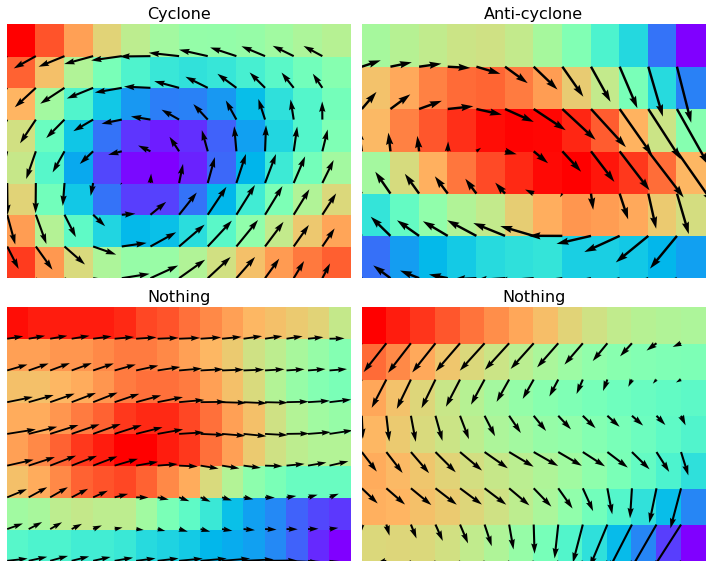

In [8]:
dirpath = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/'

ssl = []
uvel = []
vvel = []

data = np.empty((4, 3), dtype=object)

# anti, nothing, nothing, cyclone 1509
#for i, eddyId in enumerate((293, 1535, 1573, 1504)):
for i, eddyId in enumerate((1541, 1550, 1532, 1522)):
    for j, fpath in enumerate((dirpath+'ssl_train.npz', dirpath+'uvel_train.npz', dirpath+'vvel_train.npz')):
        with np.load(fpath, allow_pickle=True) as h5f:
            data[i,j] = h5f['arr_0'][eddyId,0]
            
fig, ax = plt.subplots(2,2,figsize=(10,8))

ax[0,0].pcolormesh(data[0,0].T, cmap='rainbow')
ax[0,0].quiver(data[0,1].T, data[0,2].T, scale=4)     
ax[0,0].axis('off')
ax[0,0].set_title("Cyclone", fontsize=16)

ax[0,1].pcolormesh(data[1,0].T, cmap='rainbow')
ax[0,1].quiver(data[1,1].T, data[1,2].T, scale=2) 
ax[0,1].axis('off')
ax[0,1].set_title("Anti-cyclone", fontsize=16)

ax[1,0].pcolormesh(data[2,0].T, cmap='rainbow')
ax[1,0].quiver(data[2,1].T, data[2,2].T, scale=1.2) 
ax[1,0].axis('off')
ax[1,0].set_title("Nothing", fontsize=16)

ax[1,1].pcolormesh(data[3,0].T, cmap='rainbow')
ax[1,1].quiver(data[3,1].T, data[3,2].T, scale=1.2) 
ax[1,1].axis('off')
ax[1,1].set_title("Nothing", fontsize=16)

plt.tight_layout()

## Plot variables

In [ ]:
dirpath = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/'

ssl = []
uvel = []
vvel = []

data = np.empty((2, 4), dtype=object)

# anti, nothing, nothing, cyclone 1509
for i, eddyId in enumerate((697, 651)):
    for j, fpath in enumerate((dirpath+'ssl_train.npz', dirpath+'sst_train.npz', dirpath+'uvel_train.npz', dirpath+'vvel_train.npz')):
        with np.load(fpath, allow_pickle=True) as h5f:
            data[i,j] = h5f['arr_0'][eddyId,0]

fig, ax = plt.subplots(2,4,figsize=(14,6))

ax[0,0].pcolormesh(data[0,0].T, cmap='rainbow') 
ax[0,0].set_title("SSH", fontsize=16)
ax[0,0].set_ylabel('Cyclone', fontsize=16)
ax[0,0].axes.xaxis.set_ticks([])
ax[0,0].axes.yaxis.set_ticks([])

ax[0,1].pcolormesh(data[0,1].T, cmap='rainbow')
ax[0,1].axes.xaxis.set_ticks([])
ax[0,1].axes.yaxis.set_ticks([])
ax[0,1].set_title("SST", fontsize=16)

ax[0,2].pcolormesh(data[0,2].T, cmap='rainbow')
ax[0,2].axes.xaxis.set_ticks([])
ax[0,2].axes.yaxis.set_ticks([])
ax[0,2].set_title("uvel", fontsize=16)

ax[0,3].pcolormesh(data[0,3].T, cmap='rainbow')
ax[0,3].axes.xaxis.set_ticks([])
ax[0,3].axes.yaxis.set_ticks([])
ax[0,3].set_title("vvel", fontsize=16)

ax[1,0].pcolormesh(data[1,0].T, cmap='rainbow') 
ax[1,0].set_ylabel('Anti-cyclone', fontsize=16)
ax[1,0].axes.xaxis.set_ticks([])
ax[1,0].axes.yaxis.set_ticks([])

ax[1,1].pcolormesh(data[1,1].T, cmap='rainbow')
ax[1,1].axes.xaxis.set_ticks([])
ax[1,1].axes.yaxis.set_ticks([])

ax[1,2].pcolormesh(data[1,2].T, cmap='rainbow')
ax[1,2].axes.xaxis.set_ticks([])
ax[1,2].axes.yaxis.set_ticks([])

ax[1,3].pcolormesh(data[1,3].T, cmap='rainbow')
ax[1,3].axes.xaxis.set_ticks([])
ax[1,3].axes.yaxis.set_ticks([])



plt.tight_layout()

## Show feature maps

In [ ]:
cnn.train_model()

In [ ]:
import keras.models
import tensorflow as tf
import cv2
from sklearn.externals import joblib
import cnn

importlib.reload(cnn)

data = []

dirpath = 'C:/Users/47415/Master/TTK-4900-Master/data/training_data/2016/'
with np.load(dirpath+'uvel_train.npz', allow_pickle=True) as h5f:
    data.append(h5f['arr_0'][293,0])
with np.load(dirpath+'vvel_train.npz', allow_pickle=True) as h5f:
    data.append(h5f['arr_0'][293,0])

fig, ax = plt.subplots(1,2,figsize=(10,8))
ax[0].pcolormesh(data[0])
ax[1].pcolormesh(data[1])
    
#winW, winH = int(11*6), int(6*6)
winW, winH = 40, 40
cnn_data = np.zeros((1, winW, winH, 2))
resized_data = np.zeros((2, winW, winH))

custom_objects  = {
    "f1_m": cnn.f1_m,
    "precision_m": cnn.precision_m, 
    "recall_m": cnn.recall_m
}
#'D:/Master/models/best_model_975.h5'
clf = keras.models.load_model('D:/Master/models/best_ever_model.h5', custom_objects=custom_objects)

scaler = joblib.load("D:/Master/models/2016/cnn_scaler.pkl") # Import the std sklearn scaler model

for i in range(2):
    resized_data[i] = cv2.resize(data[i], dsize=(winH, winW), interpolation=cv2.INTER_CUBIC)
    tmp = resized_data[i].flatten()
    tmp = scaler[i].transform([tmp])[0]
    cnn_data[0,:,:,i] = tmp.reshape(winW, winH)
    
# Extracts the outputs of the top 12 layers
layer_outputs = [layer.output for layer in clf.layers[:17]] 

# Creates a model that will return these outputs, given the model input
activation_model = keras.models.Model(inputs=clf.input, outputs=layer_outputs) 

activations = activation_model.predict(cnn_data) 

fig, ax = plt.subplots(1,2,figsize=(10,8))
ax[0].pcolormesh(resized_data[0])
ax[1].pcolormesh(resized_data[1])



In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.quiver(data[0].T, data[1].T, cmap='viridis')

In [ ]:
fig, ax = plt.subplots(figsize=(6, 8))
plt.imshow(activations[0][0, :, :, 0], cmap='viridis')
ax.axis('off')

In [ ]:
fig, ax = plt.subplots( figsize=(15, 10))

ax1 = plt.subplot2grid((3, 8), (0, 1), colspan=2)
ax1.matshow(resized_data[0], cmap='viridis')
ax1.axis('off')
ax1.set_title('uvel')

ax1 = plt.subplot2grid((3, 8), (1, 0), colspan=2)
ax1.matshow(activations[0][0, :, :, 0], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((3, 8), (1, 2), colspan=2)
ax1.matshow(activations[0][0, :, :, 2], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((3, 8), (2, 0), colspan=2)
ax1.matshow(activations[0][0, :, :, 4], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((3, 8), (2, 2), colspan=2)
ax1.matshow(activations[0][0, :, :, 6], cmap='viridis')
ax1.axis('off')

ax1 = plt.subplot2grid((3, 8), (0, 5), colspan=2)
ax1.matshow(resized_data[1], cmap='viridis')
ax1.axis('off')



#ax1 = plt.subplot2grid((3, 8), (1, 4), colspan=2)
#ax1 = plt.subplot2grid((3, 8), (1, 6), colspan=2)

#line = plt.Line2D((.51,.51),(.22,.82), color="k", alpha=0.5, linewidth=3, linestyle='--')
#fig.add_artist(line)



ax.text(0.95, 0.01, 'colored text in axes coords',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=15)


In [ ]:
fig, ax = plt.subplots( figsize=(15, 30))

ax1 = plt.subplot2grid((4, 4), (0, 1), colspan=2)
ax1.matshow(resized_data[0], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
ax1.matshow(activations[0][0, :, :, 0], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
ax1.matshow(activations[0][0, :, :, 2], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((4, 4), (2, 0), colspan=2)
ax1.matshow(activations[0][0, :, :, 4], cmap='viridis')
ax1.axis('off')
ax1 = plt.subplot2grid((4, 4), (2, 2), colspan=2)
ax1.matshow(activations[0][0, :, :, 6], cmap='viridis')
ax1.axis('off')


In [ ]:

for i in range(4):
    for j in range(4):
        idx = (i*4+j)*2+1

        ax[i,j].matshow(activations[0][0, :, :, idx], cmap='viridis')
        ax[i,j].axis('off')

fig, ax = plt.subplots(4,4,figsize=(10,8))        
fig.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(4):
    for j in range(4):
        idx = (i*4+j)*2+1

        ax[i,j].matshow(activations[1][0, :, :, idx], cmap='viridis')
        ax[i,j].axis('off')
        
plt.show()

In [ ]:
layer_names = []
for layer in clf.layers[:17]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

i = 0

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps

    i += 1
    print(i)
    
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            #channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            #channel_image /= channel_image.std()
            #channel_image *= 64
            #channel_image += 128
            #channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            # Displays the grid 
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')